Data example
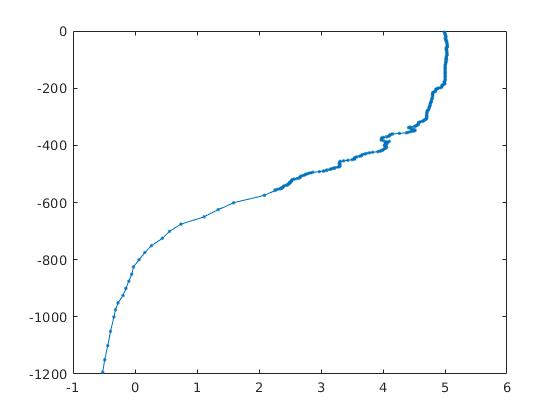

## QI index
To select the proper MLD
- https://doi.org/10.1175/JTECH-D-17-0104.1


In [32]:
def QI_fhaijijielov-patch-1or_MLD(pres,dens,mld):
    pres=pd.Series(pres)
    dens=pd.Series(dens)
    s1=dens[pres<mld].std(skipna=True)
    s2=dens[pres<mld*1.5].std(skipna=True)
    QI=1-s1/s2
    return QI



In [99]:
# e.g.:
import pandas as pd
h=pd.read_csv('Temp4mld.csv')
degree=0.3
pres=h.pres
dens=h.temp
mld=MLD_estimation_Huang(pres, dens)
QI=QI_for_MLD(pres,dens,mld)


0.8090823687927021

## MLD_estimation_Huang et al., 2018
- https://journals.ametsoc.org/view/journals/atot/35/3/jtech-d-17-0104.1.xml
- The mean depth resolution is ≤2 dbar;

In [2]:
def MLD_estimation_Huang(pres, dens,degree=0.3):
    Chi=list()
    Chi.append(1)
    Chi.append(1)
    for k in range(2, len(pres)):
        pres=pd.Series(pres)
        dens=pd.Series(dens)
        x=pres[0:k]
        delta=dens[0:k].std(skipna=True)
        sigma=dens[0:k].max(skipna=True)-dens[0:k].min(skipna=True) #max-min
        Chi.append(delta/sigma)
    Chi=pd.Series(Chi)
    n1=Chi.idxmin(skipna=True)
    ratio_down=dens[0:n1+1].std(skipna=True)-dens[0:n1].std(skipna=True)
    for n2 in range(n1,2,-1):
        ratio_up=dens[0:n2+1].std(skipna=True)-dens[0:n2].std(skipna=True)
        if abs(ratio_up/ratio_down) <= degree:
            mld=pres[n2]
            break
    return mld

In [4]:
# e.g.:
import pandas as pd
h=pd.read_csv('Temp4mld.csv')
degree=0.3
pres=h.pres
temp=h.temp
MLD_estimation_Huang(pres, temp)

188.27000427246102

## MLD_estimation_MLD_estimation_Holte_Talley., 2009

In [85]:
def data_to_pdseries(pres,prof):
    import numpy as np
    pres=np.array(pres)
    prof=np.array(prof)
    pres=pres[(~np.isnan(pres)) & (~np.isnan(prof))]
    prof=prof[(~np.isnan(pres)) & (~np.isnan(prof))]
    return [pres,prof]

### 1. de Boyer Montégut et al. (2004)

0.2 ◦C and 0.03 kg m−3 are used as the threshold difference criteria and the Argo measurement closest to 10 dbar as the surface reference value.

In [108]:
def MLD_Threshold(pres,prof,pres_ref=10,threshold=-0.2):
    ## default is temp:de Boyer Montégut et al.(2004)
    ## for potential density, MLD_Threshold(pres,dens,10,0.03)
    ## for temperature, MLD_Threshold(pres,temp,10,-0.2) ### ATTENTION:threshold is 'minus 0.2' for temperature
    import numpy as np
    [pres,prof]=data_to_pdseries(pres,prof)
    if pres[-1]<=pres_ref:
        mld=nan;
        return mld
    data_ref=np.interp(pres_ref,pres, prof)
    data_mld=data_ref+threshold
    mld_i=np.argmin(abs(prof-data_mld))
    mld=np.interp(data_mld,prof[mld_i-1:mld_i+1],pres[mld_i-1:mld_i+1])
    # print(pres[mld_i],mld)
    return mld,data_ref,data_mld


In [124]:
# e.g.:
import numpy as np
h=pd.read_csv('eg_data_good.csv')
pres=h.pres
prof=h.temp
[pres,prof]=data_to_pdseries(pres,prof)
mld_T_0p2,data_ref,data_mld=MLD_Threshold(pres,prof,pres_ref=10,threshold=-0.2)

Text(0.5, 1.0, 'Temp')

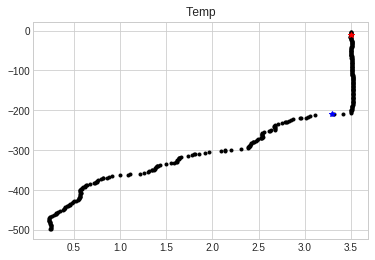

In [118]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(prof[pres<500], -pres[pres<500], '.', color='black');
plt.plot(data_ref,-10,'*',color='red')
plt.plot(data_mld,-mld_T_0p2,'*',color='blue')
plt.title('Temp')

In [125]:
# e.g.:
import numpy as np
h=pd.read_csv('eg_data_good.csv')
pres=h.pres
prof=h.dens
[pres,prof]=data_to_pdseries(pres,prof)
mld_D_0p03,data_ref,data_mld=MLD_Threshold(pres,prof,pres_ref=10,threshold=0.03)

Text(0.5, 1.0, 'Dens')

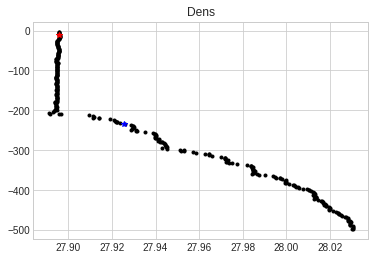

In [120]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(prof[pres<500], -pres[pres<500], '.', color='black');
plt.plot(data_ref,-10,'*',color='red')
plt.plot(data_mld,-mld_D_0p03,'*',color='blue')
plt.title('Dens')

## 2. Dong et al. (2008) 

The algorithm uses a potential density gradient criterion of 0.0005 kg m −3 dbar −1 . It uses a temperature gradient criterion of 0.005 ◦ C dbar −1
## but here I changed the density criterion same as temp, because 0.0005 is too shallow.

In [191]:
def MLD_Grad_Dong2008(pres,prof,threshold=0.005):
    import numpy as np
    [pres,prof]=data_to_pdseries(pres,prof)
    grad0=abs(np.gradient(prof, pres))
    from scipy.ndimage import median_filter as medfilter
    gradiant=medfilter(grad0,3)
    mld_i=np.where(gradiant>threshold)[0][0]
    mld=pres[mld_i]
    return mld,mld_i,grad0,grad

In [193]:
h=pd.read_csv('eg_data_good.csv')
pres=h.pres
prof=h.temp
mld_grad_T,mld_i,grad0,grad=MLD_Grad_Dong2008(pres,prof,threshold=0.005)

Text(0.5, 1.0, 'grad_temp')

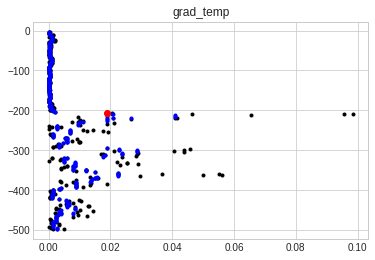

In [194]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(grad0[pres<500], -pres[pres<500], '.', color='black');
plt.plot(grad[pres<500], -pres[pres<500], '.', color='blue');
plt.plot(grad[mld_i], -pres[mld_i], 'o', color='red');
plt.title('grad_temp')


Text(0.5, 1.0, 'Temp')

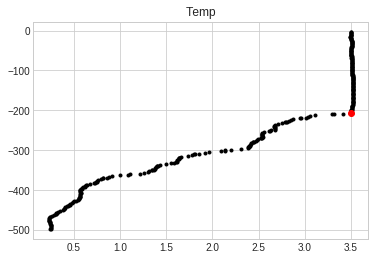

In [195]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(prof[pres<500], -pres[pres<500], '.', color='black');
plt.plot(prof[mld_i], -mld_grad_T, 'o', color='red');
plt.title('Temp')

In [200]:
h=pd.read_csv('eg_data_good.csv')
pres=h.pres
prof=h.dens
mld_grad_D,mld_i,grad0,grad=MLD_Grad_Dong2008(pres,prof,threshold=0.005)

Text(0.5, 1.0, 'grad_dens')

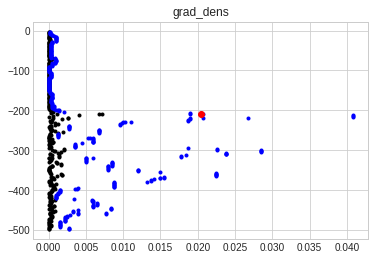

In [201]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(grad0[pres<500], -pres[pres<500], '.', color='black');
plt.plot(grad[pres<500], -pres[pres<500], '.', color='blue');
plt.plot(grad[mld_i], -pres[mld_i], 'o', color='red');
plt.title('grad_dens')

Text(0.5, 1.0, 'Dens')

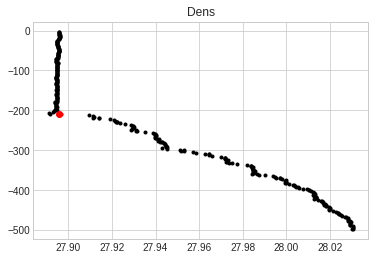

In [202]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(prof[pres<500], -pres[pres<500], '.', color='black');
plt.plot(prof[mld_i], -mld_grad_D, 'o', color='red');
plt.title('Dens')

## 3. Straight line fit algorithm
Error_T = 10^ −10

It finds the first depth where the error exceeds the tolerance
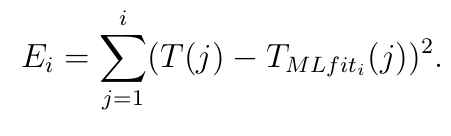
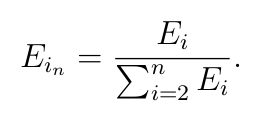
### 10^-10 is too small, here use Temp_err=10^-4 Pdens_err=10^-6   

In [269]:
def MLD_line_fit(pres,prof,err_threshold=10**(-4)):
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error as MSE
    regr = linear_model.LinearRegression()
    mse=np.zeros(pres.shape)
    for i in range(3,len(prof)):
        pres_i=pres[0:i]
        prof_i=prof[0:i]
        model=np.polyfit(pres_i,prof_i, 1)
        predict = np.poly1d(model)
        prof_pred = predict(pres_i)
        mse[i]=MSE(prof_i, prof_pred)
    from scipy.ndimage import median_filter as medfilter
    mse=medfilter(mse,3)
    mse=medfilter(mse,3)
    mld_i=np.where(mse>err_threshold)[0][0]
    mld=pres[mld_i]
    return mld,mld_i,mse


In [292]:
## Temp
h=pd.read_csv('eg_data_good.csv')
pres=h.pres
prof=h.temp
mld,mld_i,mse=MLD_line_fit(pres,prof,err_threshold=10**(-4))
mld

210.154998779297

Text(0.5, 1.0, 'MSE')

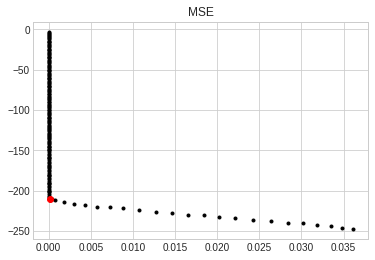

In [279]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(mse[pres<250], -pres[pres<250], '.', color='black');
plt.plot(mse[mld_i], -pres[mld_i], 'o', color='red');
plt.title('MSE')


Text(0.5, 1.0, 'MSE_grad')

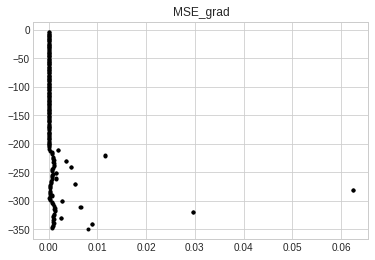

In [277]:
grad=abs(np.gradient(mse, pres))
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(grad[pres<350], -pres[pres<350], '.', color='black');
plt.title('MSE_grad')

In [291]:
## Pdens
h=pd.read_csv('eg_data_good.csv')
pres=h.pres
prof=h.dens
mld,mld_i,mse=MLD_line_fit(pres,prof,err_threshold=10**(-6))
mld

214.154998779297

Text(0.5, 1.0, 'MSE')

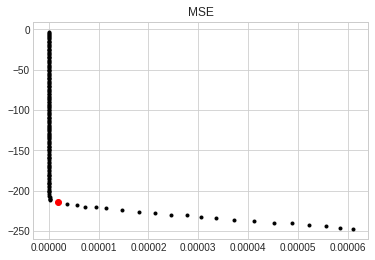

In [289]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(mse[pres<250], -pres[pres<250], '.', color='black');
plt.plot(mse[mld_i], -pres[mld_i], 'o', color='red');
plt.title('MSE')


Text(0.5, 1.0, 'MSE_grad')

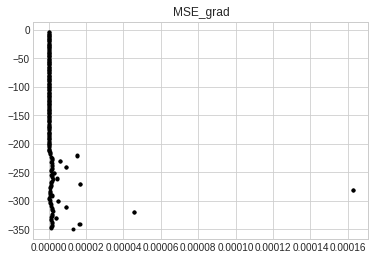

In [290]:
grad=abs(np.gradient(mse, pres))
## plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(grad[pres<350], -pres[pres<350], '.', color='black');
plt.title('MSE_grad')

## MLD_estimation_MLD_estimation_Lorbacher et al, 2006

In [17]:
def MLD_estimation_Lorbacher(z,t):# z--depth t--temp
    # gradients; resolution; 30m variance
    [gt, res, sig30]=gradients(z,t)
    # hit bottom if no significant variability is in the profile
    if (max(sig30)<0.02):
        mld=min(z) 
        return mld
    # check the range in which the mld can be found
    imld0=first_guess(z,t,abs(gt),sig30)
    # find level closest to mld
    [imld,ipo]=mld_0level(z,t,imld0,gt,res,sig30)
    # interpolation between levels
    mld=interpol(z,t,gt,imld,ipo)
    return mld


In [2]:
# ################     FUNCTION  gradients   #######################
def gradients(z,t): #[gt, res, sig30]=gradients(z,t)
    smoo=5 # gradients are calculated over at least 5m for a smoother estimate
    gt=np.zeros(len(z))*np.nan
    sig30=np.zeros(len(z))*np.nan
    res=np.zeros(len(z))*np.nan
    ldim=len(z) 
    gt[ldim-1]=0
    sig30[ldim-1]=0
    for i in range(0,ldim-1):
    # find level smoo meter below current level for gradients
        i2=min(ldim,i+1)
        while ( (i2<ldim-1) and (z[i]-z[i2]<=smoo)):
            i2=i2+1
        # gradients
        gt[i]=max(-0.6,min(0.6,(t[i]-t[i2])/(z[i]-z[i2])))
        # resolution
        res[i]=max(0.1,z[i]-z[min(ldim,i+1)])
        # find level 30m below current level for sig30
        if (z[i]-z[ldim-1]> 30.0):
            cdt=(z[i]-z[i+1:ldim]-30)>0
            i2=cdt.index(True)+i

        if (z[i]-z[ldim-1]<=30.0):
            i2=ldim
        #  standard deviation over 30m below current level, sig30
        sig30[i]=np.std(t[i:i2])

        if (z[i]-z[ldim-1]<30.0):
            sig30[i]=0.0
    res[ldim-1]=res[ldim-2]
    return [gt, res, sig30]

In [ ]:
# ################     FUNCTION  first_guess   #######################
import numpy as np
def first_guess(z,t,gt,sig30):
    import numpy as np
    # find first level that exceeds a significant gradient & sig30
    cndt=(gt-0.25*max(gt)>0) & (sig30>0.02)
    if len(cndt[cndt])>0:
        imld=cndt.tolist().index(True)
    else:
        imld=len(z)
        imld=max([imld,3])
    return imld

In [ ]:
# ################     FUNCTION  mld_0level   #######################
def mld_0level(z,t,imld0,gt,res,sig30):# [imld, ipo] = mld_0level(z,t,imld0,gt,res,sig30)
    #   find local extreme in curvature with some  boundary conditions
    #   and decide how to interpolate

    # gradient threshold
    sgtl=max([0.002,min(0.005,np.std(gt[0:imld0]))])  # low resolution
    sgth=max([0.004,min(0.01,np.std(gt[0:imld0]))])   # high resolution
    ct=np.zeros(len(z))*np.nan
    # curvature
    ct[0]=0

    for i in range(1,len(gt)):
        ct[i]=(gt[i]-gt[i-1])/(z[i-1]-z[i])
    # find local extreme in ct
    i=0 
    imld=0
    while (imld==0 and (i<imld0-1)):

        cdt_1= (gt[i]>=0) and (ct[i]>0)and (ct[i]>max( ct[[max(0,i-1),i]]))#local maxim
        cdt_2= (-gt[i]>0)and(-ct[i]>0) and (-ct[i]> max(-ct[[max(0,i-1),i]]))#local minim
        cdt_3=sig30[i]-0.02>0 # signifcant t-cline
        cdt_4= (res[i]<6.0) and (abs(gt[i])>sgth)                   #signifcant gradient
        cdt_5=(res[i]>=6.0)and (abs(gt[i])>sgtl)                 #signifcant gradient
        if  cdt_1 or cdt_2 and cdt_3 and cdt_4 or cdt_5:
               imld=i#local extreme found
        i=i+1


    # no local extreme in gradient change => take first level > 0.7 maxgt
    if (imld==0):
        cdx=abs(gt[0:imld0])>0.7*max(abs(gt[0:imld0]))
        imld=cdx.tolist().index(True)

    # check for interpolation
    ipo=0 
    ldim=len(z)
    resi=max(res[max(0,imld-1):min(ldim,imld+2)])
    # linear interpolation possible in the interval [z(imld-1) z(imld)]
    if ( imld!=1 and imld<ldim ):
        ipo=2
        if ( resi < 6 ):
            # high resolution always linear interpolation
            ipo=2
        else:
            # low resolution check if exponential interpolation possible
            if ( imld+3 <= ldim ):
                ipo=1
                if (gt[imld+1]/gt[imld]>=1.0):
                    ipo=2             # NO, not convex
                if (ipo==2 and abs(gt[imld+2]/gt[imld+1]-0.5)<0.5 and gt[imld-1]/gt[imld]<0.1 ):
                    imld=imld+1 
                    ipo=1  # but convex for imld+1
                if (abs(gt[imld+1]/gt[imld]-0.875)<0.125 and gt[imld-1]/gt[imld]>0.1):
                    ipo=2      # doubtful gradients
                if  (gt(imld+1)/gt(imld)<=0.0):
                    ipo=2            # change of sign
        if (resi<6):
            sgt=sgth 
        if (resi>=6):
            sgt=sgtl 
        if (ipo==2 and ( abs(gt[imld-1]/gt[imld]-0.05)<0.05 or abs(gt[imld-1])<sgt ) ) :
            imld=imld+1
    return [imld,ipo]

In [ ]:
# ################     FUNCTION  interpol   #######################
# interpolation in the interval [z[imld-1] z[imld]]
def interpol(z,t,gt,imld,ipo):
    #  interpolation by exponential fit f(z) = C+A*exp(B*z)
    if (ipo==1):
        for i in range(0,2):
            x[i]=(abs(z[imld+i-1])+abs(z[imld+i]))/2
            dy[i]=log(sign(t[imld]-t[imld+1])*gt[imld+i-1])
        s1=sum(x[0:2]*dy[0:2]) 
        s2=sum(x[0:2])*sum(dy[0:2])/2
        if (s1-s2==0) :
            return
        s3=sum(x[0:2]**2)      
        s4=sum(x[0:2])*sum(x[0:2])/2
        if (s3-s4==0):
            return
        b=(s1-s2)/(s3-s4) 
        a=sum(dy[0:2])/2-b*sum(x[0:2])/2 
        B=-b
        if (a<=0):
            return
        A=exp(a)/B
        C=1/(2+1)*(sum(t[imld:imld+3])-sum(A*exp(-abs(z[imld:imld+3])*B)) )
        x1[0:3]=t[imld:imld+3]
        x2[0:3]=C+A*exp(-B*abs(z[imld:imld+3]))
        ans=corrcoef(x1,x2) 
        r=ans[1,2]
        tref=mean(t[1:max(0,imld-2)])
        tx=mean(x2)+std(x2)/std(x1)*r*(tref-mean(x1))
        mld=-abs(log((tx-C)/A)/(-B))

        # empirical correction based on observational errors
        # it shifts the mld further up from the level-imld
        # it reflects the fact that the exponential profile below the mld does
        #    break down near the mld, it continues with a smaller gradient
        #    (a smooth transition zone)
        if ( mld-z[imld] <= 0.4*(z[imld-1]-z[imld]) ):
             mld=z[imld]+2.5*(mld-z[imld])-0.1*(z[imld-1]-z[imld])

        # interpo overshoot -> empirical correction based on observational errors
        # (better than setting mld onto a level)
        if (mld>=z[imld-1]):
            if( gt[imld-1]<0.01*(z[imld-1]-z[imld]) ):
                dd=0.5*(1-min(1,gt(imld+2)/gt[imld]))-0.25
            else:
                dd=10*gt[imld-1]

            if(gt(imld+2)/gt[imld]>1.0):
                mld=z[imld-1]-0.25*(z[imld-1]-z[imld])
            else:
                mld=z[imld-1]+dd*(z[imld-1]-z[imld])

    # linear  interpolation
    if (ipo==2):
        if ( gt[imld]/gt[imld-1] > 1.0 ):
            dx=(t[imld-1]-t[imld])/((gt[imld]+gt[imld-1])/2)
        else:
       # linear interpolation would overshoot: find a dT to go down from imld-1
           dt=max( [0.01,abs(  diff(t[1:imld-1].T)) ] )
           dx=sign(t[imld]-t[imld-1])*dt/gt[imld-1]-(z[imld]-z[imld-1])

       # empirical correction based on observational errors
        if (1/4*(z[imld-1]-z[imld])<dx and dx<3/4*(z[imld-1]-z[imld])):
            dx=dx+(z[imld-1]-z[imld])/5

        mld=z[imld]+dx
    # interpolation must be within [z[imld-1], z(imld+1)]
    # interpolation must be within [z[imld-1], z(imld+1)]
    if (mld > z[max(1,imld-1)]):    
        mld=z[max(1,imld-1)]  
    if (mld < z[min(ldim,imld+1)]):
        mld=z[min(ldim,imld+1)]
    return mld

In [18]:
import numpy as np
# e.g.:
import pandas as pd
h=pd.read_csv('Temp4mld.csv')
pres=h.pres
temp=h.temp
mld=MLD_estimation_Lorbacher(pres, temp)
print(mld)

4.57000017166138


### Original Matlab code:
z=Temp4mld.pres;

t=Temp4mld.temp;

[mld, qe, imf] = MLD_GRADIANT(z,t)% 

%% mld = 4.57000017166138